In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import joblib
from random import randint
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import itertools

In [65]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
Housing_price=pd.read_csv('Beijing_housing_price.csv') #, sep=',', encoding='iso-8859-1', low_memory=False
Housing_price.head()

,Lng,Lat,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,116.475489,40.019520,8/9/16,1464,106,415.0,31680,131.00,2,1,...,1,2005,3,6,0.217,1,0,1,7,56021
1,116.453917,39.881534,7/28/16,903,126,575.0,43436,132.38,2,2,...,1,2004,4,6,0.667,1,1,0,7,71539
2,116.561978,39.877145,12/11/16,1271,48,1030.0,52021,198.00,3,2,...,4,2005,3,6,0.500,1,0,0,7,48160
3,116.438010,40.076114,9/30/16,965,138,297.5,22202,134.00,3,1,...,1,2008,1,6,0.273,1,0,0,6,51238
4,116.428392,39.886229,8/28/16,927,286,392.0,48396,81.00,2,1,...,4,1960,2,2,0.333,0,1,1,1,62588


In [6]:
cols = [i for i in Housing_price.columns if i not in ['tradeTime']]
for col in cols:
    Housing_price[col] = pd.to_numeric(Housing_price[col], errors = 'coerce')
Housing_price['tradeTime'] = pd.to_datetime(Housing_price['tradeTime'], format = '%m/%d/%y')

Housing_price=Housing_price.drop(['constructionTime'], axis=1)

In [7]:
Housing_price.head()

,Lng,Lat,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,...,bathRoom,buildingType,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,116.475489,40.019520,2016-08-09,1464,106,415.0,31680,131.00,2,1,...,1,1,3,6,0.217,1,0,1,7,56021
1,116.453917,39.881534,2016-07-28,903,126,575.0,43436,132.38,2,2,...,2,1,4,6,0.667,1,1,0,7,71539
2,116.561978,39.877145,2016-12-11,1271,48,1030.0,52021,198.00,3,2,...,3,4,3,6,0.500,1,0,0,7,48160
3,116.438010,40.076114,2016-09-30,965,138,297.5,22202,134.00,3,1,...,1,1,1,6,0.273,1,0,0,6,51238
4,116.428392,39.886229,2016-08-28,927,286,392.0,48396,81.00,2,1,...,1,4,2,2,0.333,0,1,1,1,62588


### Feature Distribution

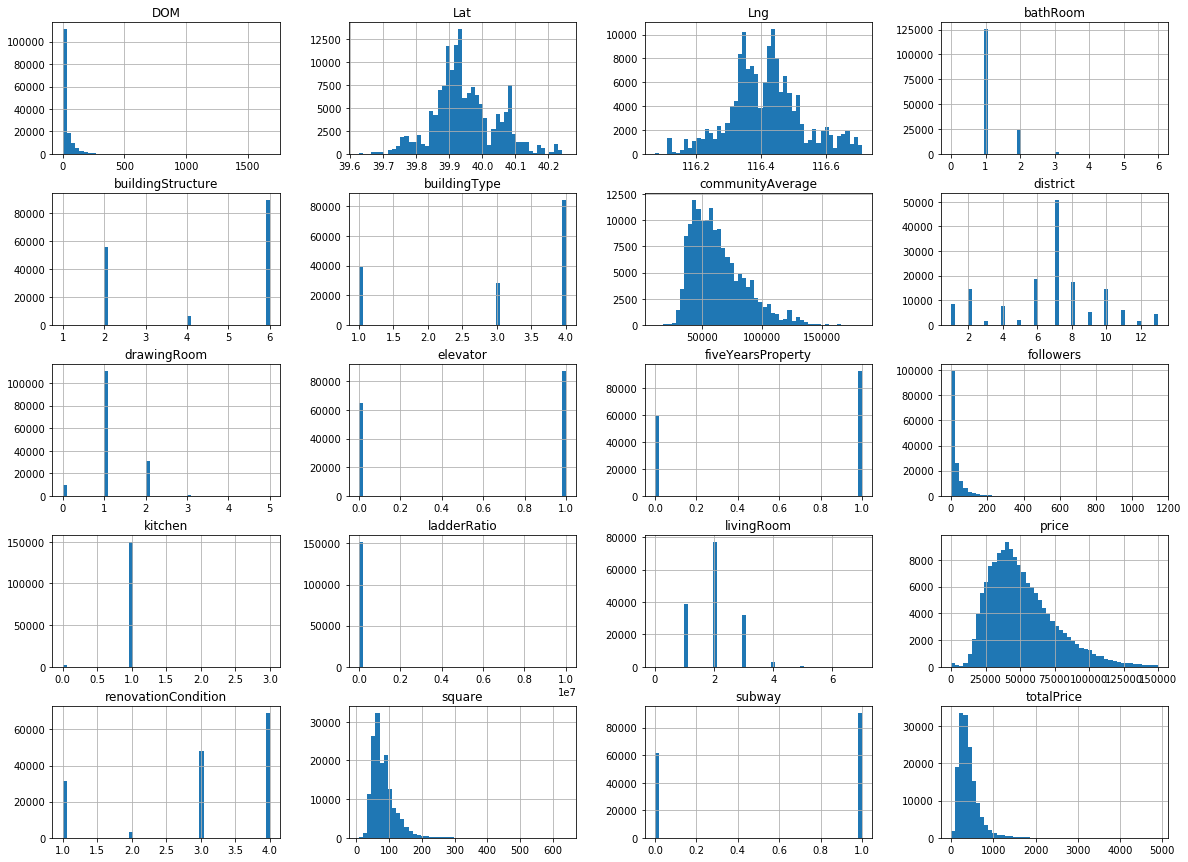

In [8]:
Housing_price.hist(bins=50, figsize=(20,15))
plt.show()

In [40]:
# Seaborn直方图 fig,axes = plt.subplots(1,1)  sns.distplot(Housing_price.totalPrice)  

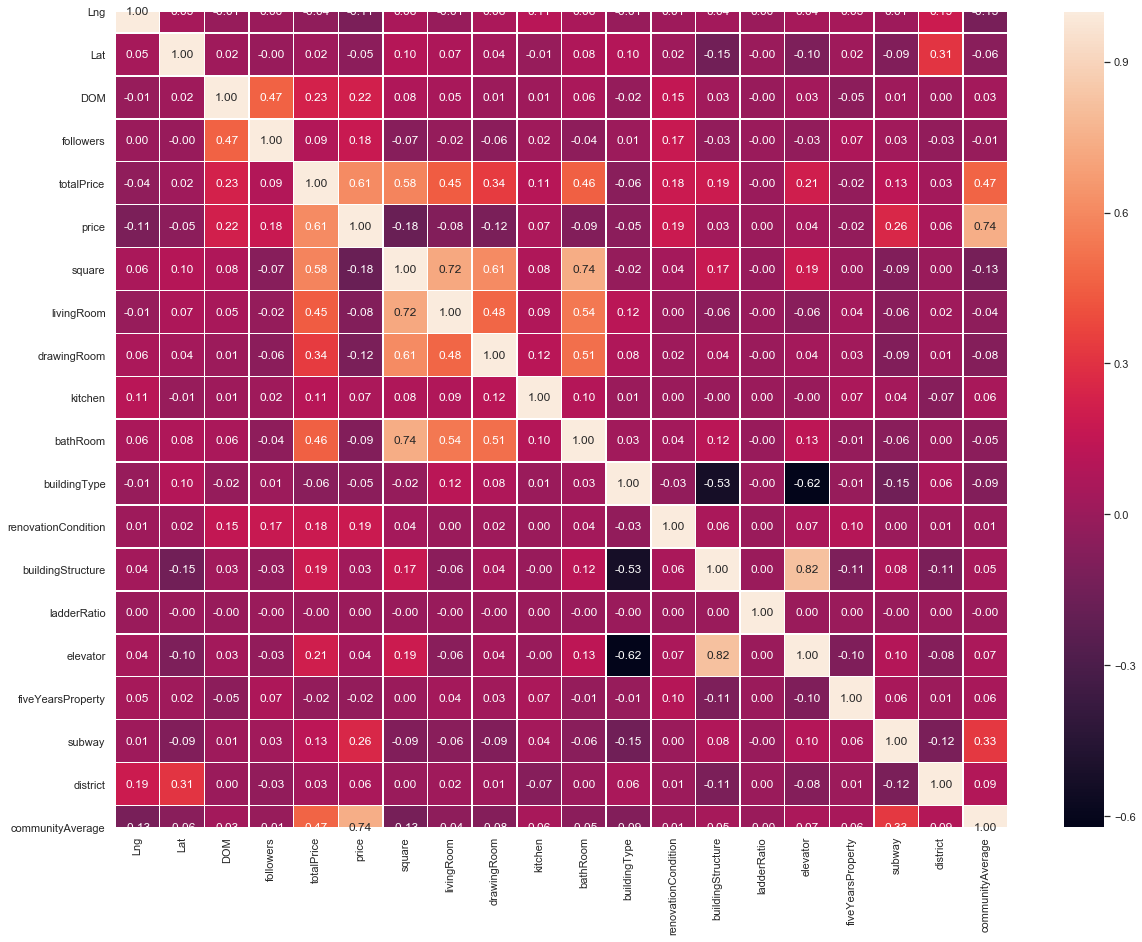

In [206]:
# correlation
f,ax = plt.subplots(figsize=(20, 15))
sns.heatmap(Housing_price.corr(), annot = True, linewidth = .5, fmt = ".2f",ax = ax)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

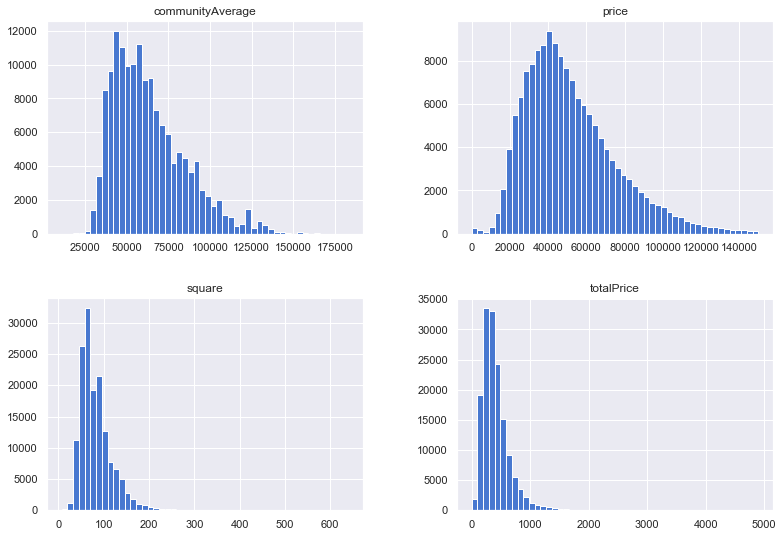

In [55]:
Housing_price.hist(['square','totalPrice','price','communityAverage'],bins=50,figsize=(13,9))
plt.show
# 均价-元；总价-万元

### Geometric distribution

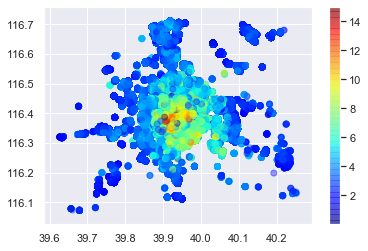

In [51]:
fig = plt.scatter(x=Housing_price['Lat'], y=Housing_price['Lng'], alpha=0.4, \
      c=Housing_price['price']/10000, cmap=plt.get_cmap('jet'))
plt.colorbar(fig)
plt.show()
# 右侧：万元

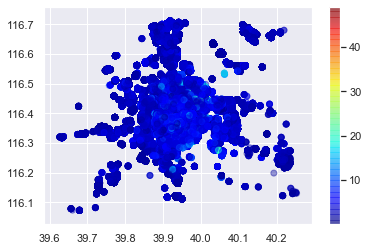

In [57]:
fig2 = plt.scatter(x=Housing_price['Lat'], y=Housing_price['Lng'], alpha=0.4, \
      c=Housing_price['totalPrice']/100, cmap=plt.get_cmap('jet'))
plt.colorbar(fig2)
plt.show()
# 右侧：万元

### Time trend

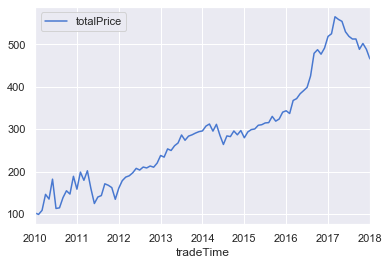

In [50]:
price_by_trade_time = pd.DataFrame()
price_by_trade_time['totalPrice'] = Housing_price['totalPrice']
price_by_trade_time.index = Housing_price['tradeTime'].astype('datetime64[ns]')
price_by_trade_month = price_by_trade_time.resample('M').mean().to_period('M').fillna(0)
price_by_trade_month.plot(kind='line')
plt.show()

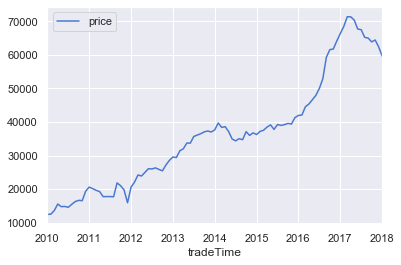

In [165]:
avg_price_by_trade_time= pd.DataFrame()
avg_price_by_trade_time['price'] = Housing_price['price']
avg_price_by_trade_time.index = Housing_price['tradeTime'].astype('datetime64[ns]')
avg_price_by_trade_month = avg_price_by_trade_time.resample('M').mean().to_period('M').fillna(0)
avg_price_by_trade_month.plot(kind='line')
plt.show()

## Part I: Regression for Price on Features

In [58]:
from sklearn.preprocessing import scale

In [59]:
# reason of dropping: totalPrice: corr too high to linear relation; corr > 0.1
X=Housing_price.drop(['totalPrice','price', 'kitchen','tradeTime'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scale(np.array(X)), scale(np.array(Housing_price['price'])), test_size=0.3, random_state=27)

In [60]:
X.head()

,Lng,Lat,DOM,followers,square,livingRoom,drawingRoom,bathRoom,buildingType,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,116.475489,40.019520,1464,106,131.00,2,1,1,1,3,6,0.217,1,0,1,7,56021
1,116.453917,39.881534,903,126,132.38,2,2,2,1,4,6,0.667,1,1,0,7,71539
2,116.561978,39.877145,1271,48,198.00,3,2,3,4,3,6,0.500,1,0,0,7,48160
3,116.438010,40.076114,965,138,134.00,3,1,1,1,1,6,0.273,1,0,0,6,51238
4,116.428392,39.886229,927,286,81.00,2,1,1,4,2,2,0.333,0,1,1,1,62588


In [61]:
print(y_train[0:50])

[ 2.80764262e-01 -1.02090698e-01  9.39741619e-01 -1.75590905e-01
 -2.08947417e-01  4.58886383e-01  4.06884187e-02 -4.44222571e-01
  3.83606611e-01  8.50473631e-01  8.25021702e-01  4.44070463e-01
  4.20127467e-02 -7.89977282e-02  9.16814189e-01  2.54172609e-02
  1.49529723e+00  2.16296549e+00  4.31406576e-01  6.54100614e-01
  1.40325643e+00 -5.55755823e-01  1.15908345e+00  1.04918329e-01
 -1.00805524e+00 -6.14109028e-01 -8.09074947e-01  2.32283672e+00
 -5.59894349e-01  2.19141622e-01  1.84897559e+00 -8.14372259e-01
 -6.77842315e-01 -1.10696599e+00 -3.56154756e-01 -1.22259638e+00
 -5.65522743e-01 -7.33133011e-01 -8.16151825e-01 -4.00561131e-01
  8.30608711e-01  1.11807345e-02 -8.62373661e-04  3.26536350e-01
 -3.68570332e-01 -2.47684013e-01  9.73448277e-02  8.62061502e-01
 -5.80297278e-01  5.57010814e-01]


## Model 1: Linear Regression

In [62]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
print(reg.coef_)
print(reg.intercept_)
reg_pred_train = reg.predict(X_train)
reg_pred_test = reg.predict(X_test)

from sklearn.metrics import mean_squared_error
print("train error: " + str(mean_squared_error(y_train, reg_pred_train)))
print("test error:  " + str(mean_squared_error(y_test, reg_pred_test)))

[-0.00645614  0.00864585  0.12913798  0.10045943 -0.13167566  0.02363206
 -0.00520953  0.02899903  0.01364418  0.15538813 -0.01048236  0.00229126
  0.01322332 -0.07871159  0.0111925  -0.0078193   0.7250996 ]
0.00019326862686334213
train error: 0.3614382348065837
test error:  0.3655102625765632


In [ ]:
# 显示回归方程
# print (reg)

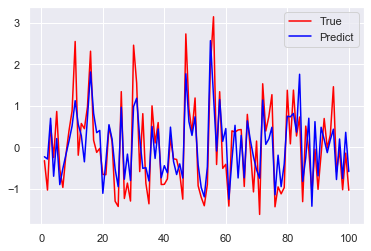

In [63]:
x = [i+1 for i in range(100)]
plt.plot(x, y_test[0:100], c='red', label='True')
plt.plot(x, reg_pred_test[0:100], c='blue', label='Predict')
plt.legend()
plt.show()

## Model 2: Linear SVR

In [66]:
lin_svm_reg = LinearSVR(C=0.5,loss='squared_epsilon_insensitive')
lin_svm_reg.fit(X_train,y_train)

LinearSVR(C=0.5, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='squared_epsilon_insensitive',
          max_iter=1000, random_state=None, tol=0.0001, verbose=0)

In [68]:
print(lin_svm_reg.coef_)
print(lin_svm_reg.intercept_)

SVM_pred_train=lin_svm_reg.predict(X_train)
SVM_pred_test=lin_svm_reg.predict(X_test)

print("train error: " + str(mean_squared_error(y_train, SVM_pred_train)))
print("test error:  " + str(mean_squared_error(y_test, SVM_pred_test)))

[-0.0064434   0.00863929  0.12954608  0.10083357 -0.13170056  0.02360902
 -0.00521121  0.02903177  0.01361606  0.15523789 -0.01050827  0.00229163
  0.0132722  -0.07872165  0.01116325 -0.00781743  0.72507466]
[0.00025171]
train error: 0.3614386708544804
test error:  0.36552033347912816


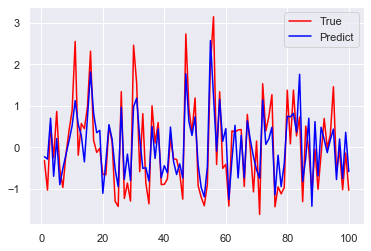

In [69]:
x = [i+1 for i in range(100)]
plt.plot(x, y_test[0:100], c='red', label='True')
plt.plot(x, SVM_pred_test[0:100], c='blue', label='Predict')
plt.legend()
plt.show()

## Model 3: Neural Network

In [74]:
from sklearn.neural_network import MLPRegressor
NN = MLPRegressor(learning_rate='adaptive', learning_rate_init=0.2)
NN.fit(X_train, y_train)

NN_pred_train = NN.predict(X_train)
NN_pred_test = NN.predict(X_test)
print("train error: " + str(mean_squared_error(y_train, NN_pred_train)))
print("test error:  " + str(mean_squared_error(y_test, NN_pred_test)))

train error: 0.34245148604400744
test error:  0.35108584223591605


In [76]:
# Changing learning_rate to 0.1
NN1 = MLPRegressor(learning_rate='adaptive', learning_rate_init=0.1)
NN1.fit(X_train, y_train)

NN1_pred_train = NN1.predict(X_train)
NN1_pred_test = NN1.predict(X_test)
print("train error: " + str(mean_squared_error(y_train, NN1_pred_train)))
print("test error:  " + str(mean_squared_error(y_test, NN1_pred_test)))

train error: 0.20308060815224954
test error:  0.2083694690684642


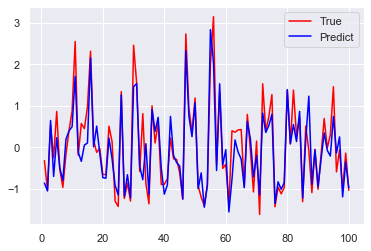

In [77]:
x = [i+1 for i in range(100)]
plt.plot(x, y_test[0:100], c='red', label='True')
plt.plot(x, NN1_pred_test[0:100], c='blue', label='Predict')
plt.legend()
plt.show()

In [78]:
print(NN1_pred_test[0:100])

[-0.85383211 -1.04279651  0.64779723 -0.69356166  0.23718469 -0.49164702
 -0.79080899  0.19521816  0.39966935  0.49732866  1.70499359 -0.11411772
 -0.33285002  0.05688617  0.1070674   2.1466609   0.01487199  0.51227451
 -0.13772875 -0.72359182 -0.73867331  0.22583074 -0.27061234 -0.91241098
 -1.13838504  1.26132571 -1.17703668 -0.65386618 -1.20957131  1.4584229
  1.53347549 -0.44938574 -0.77395171  0.09060436 -1.12325972  0.91543197
  0.38659144  0.72425042 -0.48979302 -1.12132881 -0.89655134  0.7466951
 -0.19067568 -0.36141872 -0.44546699 -1.23816959  2.32134089  0.74762433
  0.2603904   1.0719564  -0.98811421 -0.61088052 -1.43370889 -0.91522904
  2.82915542  2.03203508 -0.55321817  1.52950123 -0.41902562 -0.05213656
 -1.5474328  -0.76738636  0.18017531 -0.1105286  -0.27749951 -0.96572894
  0.62374759  0.20664073 -0.70734464 -0.19349002 -1.13852991  0.82605087
  0.360552    0.52663775  0.79849994 -1.34200697 -0.82403866 -1.00374625
 -0.84492996  1.38963675  0.088301    0.55239948  0.1

In [87]:
# not to using SALING to get real predicted price

## Part II: Time Series Regression for Price

#### Weekly Total price

In [110]:
# Using monthly average to reduce effect from uneven distribution in time
wk_price_by_trade_time = price_by_trade_time.resample('W').mean()
wk_price_by_trade_time.dropna()
wk_price_by_trade_time.head()

,totalPrice
tradeTime,
2010-01-03,165.000
2010-01-10,72.500
2010-01-17,99.000
2010-01-24,123.625
2010-01-31,73.875


In [111]:
wk_price_by_trade_time.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 422 entries, 2010-01-03 to 2018-01-28
Freq: W-SUN
Data columns (total 1 columns):
totalPrice    404 non-null float64
dtypes: float64(1)
memory usage: 6.6 KB


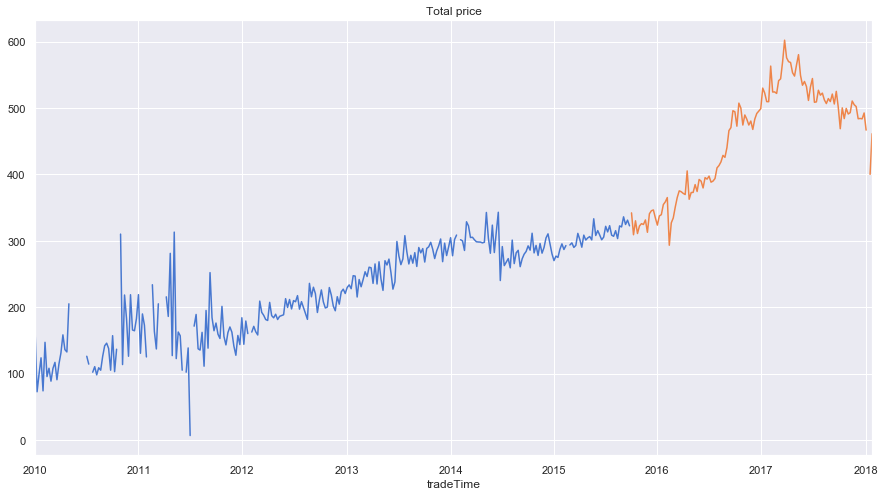

In [112]:
# Creating train and test set
train = wk_price_by_trade_time[0:300]
test = wk_price_by_trade_time[300:]

#Plotting data
train.totalPrice.plot(figsize=(15,8), title= 'Total price')
test.totalPrice.plot(figsize=(15,8), title= 'Total price')
plt.show()

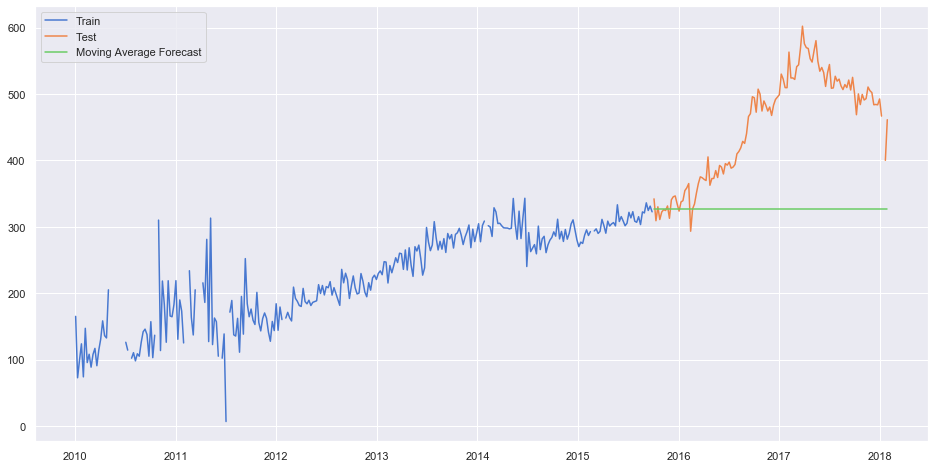

In [130]:
# MA model w/ window width=3
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['totalPrice'].rolling(3).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train['totalPrice'], label='Train')
plt.plot(test['totalPrice'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [140]:
from sklearn.metrics import mean_squared_error
from math import sqrt
 
#rms_ma = sqrt(mean_squared_error(test['totalPrice'], y_hat_avg['moving_avg_forecast']))
#print(rms_ma)

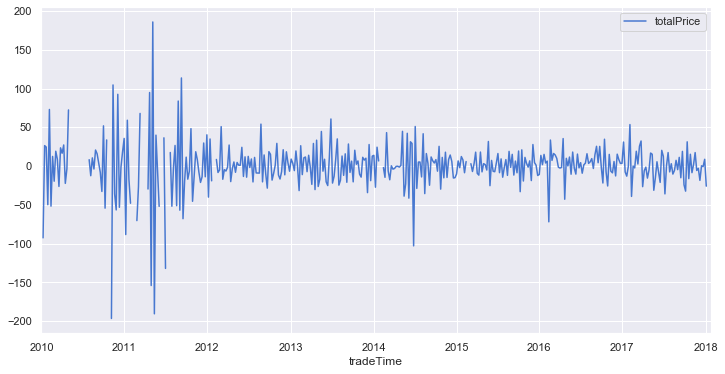

In [153]:
# ARIMA model
# finding d for arima
diff1=wk_price_by_trade_time.diff(1)
diff1.plot(figsize=(12,6))

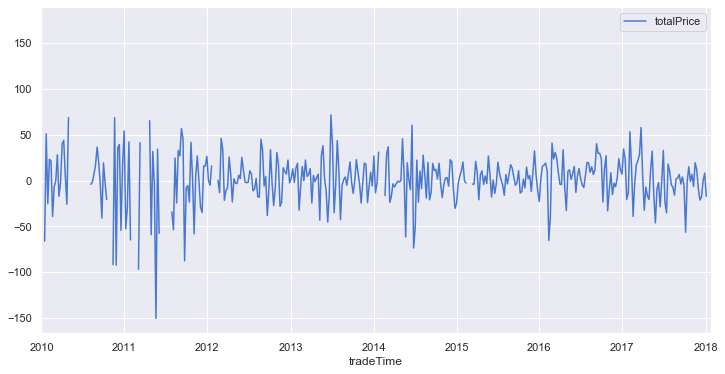

In [147]:
diff2=wk_price_by_trade_time.diff(2)
diff2.plot(figsize=(12,6))

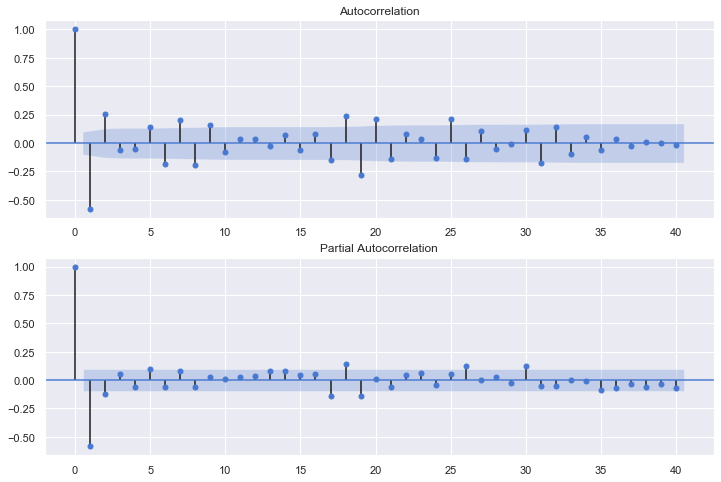

In [158]:
# acf and pacf
diff1.dropna(inplace=True)
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff1,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff1,lags=40,ax=ax2)

In [ ]:
# ACF: 2 order out of boarder, p=2; PACF: q=2

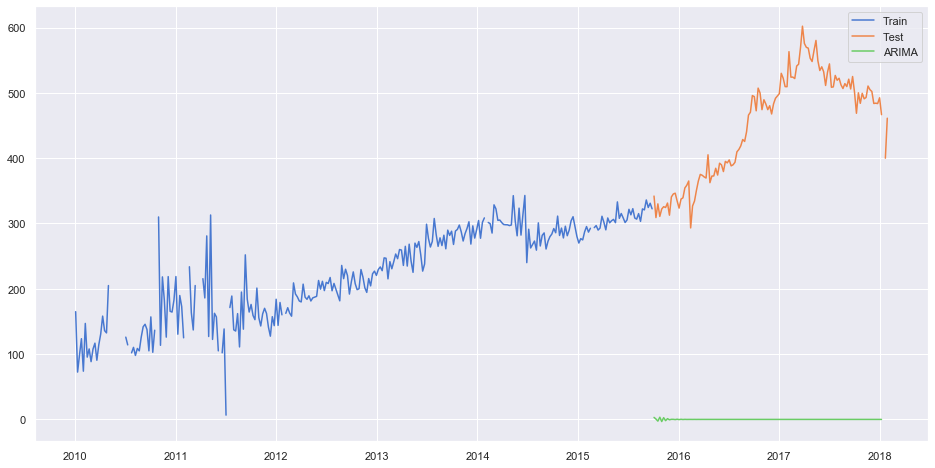

In [172]:
arima_total = test.copy()
arima212_fit = sm.tsa.ARMA(diff1,(2,2)).fit()
arima_total['ARIMA'] = arima212_fit.predict(start="2015-10-04", end="2018-01-28", dynamic=True)
plt.figure(figsize=(16, 8))
plt.plot(train['totalPrice'], label='Train')
plt.plot(test['totalPrice'], label='Test')
plt.plot(arima_total['ARIMA'], label='ARIMA')
plt.legend(loc='best')
plt.show()

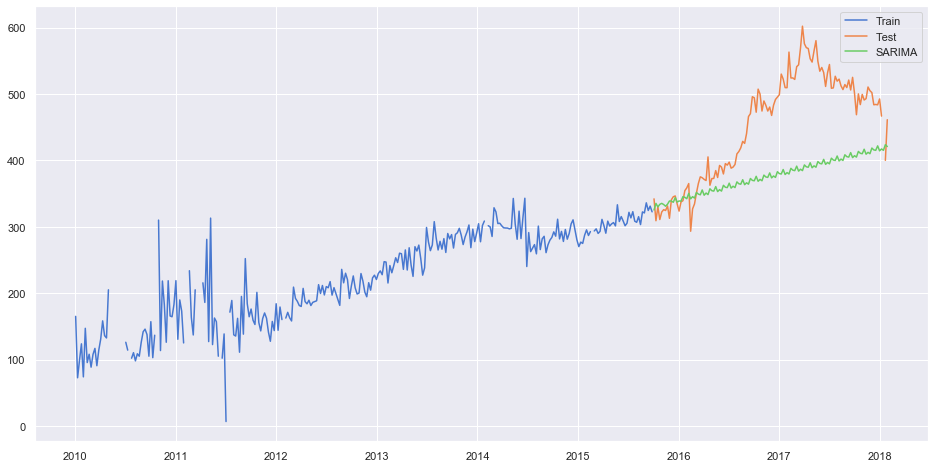

In [168]:
import statsmodels.api as sm
sarima_y_hat_avg = test.copy()
sarima_fit = sm.tsa.statespace.SARIMAX(train.totalPrice, order=(7, 1, 2), seasonal_order=(0, 1, 1, 7)).fit()
sarima_y_hat_avg['SARIMA'] = arima_fit.predict(start="2015-10-04", end="2018-01-28", dynamic=True)
plt.figure(figsize=(16, 8))
plt.plot(train['totalPrice'], label='Train')
plt.plot(test['totalPrice'], label='Test')
plt.plot(sarima_y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

#### Weekly Average price

In [166]:
avg_price_by_trade_time = avg_price_by_trade_time.sort_values(['tradeTime'],ascending=True)
avg_price_by_trade_time.head()

,price
tradeTime,
2010-01-01,13699
2010-01-05,10546
2010-01-15,12676
2010-01-16,11711
2010-01-18,12190


In [200]:
wk_avg_price_by_trade_time = avg_price_by_trade_time.resample('W').mean()
wk_avg_price_by_trade_time.dropna()
wk_avg_price_by_trade_time.tail()

,price
tradeTime,
2017-12-31,62867.532481
2018-01-07,59606.665094
2018-01-14,NaN
2018-01-21,65368.000000
2018-01-28,59908.800000


In [176]:
from fbprophet import Prophet

In [175]:
forecast = wk_avg_price_by_trade_time
forecast = forecast.rename(columns={ 'price': "y" })
forecast.reset_index(level=0, inplace=True)
forecast = forecast.rename(columns={ 'tradeTime': "ds" })

In [177]:
from scipy.stats import boxcox
forecast['y'], lam = boxcox(forecast['y'])

model = Prophet()
model.fit(forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [184]:
future = model.make_future_dataframe(periods=12, freq = 'w')
future.tail()

,ds
429,2018-03-25
430,2018-04-01
431,2018-04-08
432,2018-04-15
433,2018-04-22


In [185]:
#predicting the future model
forecast = model.predict(future)
forecast_data = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

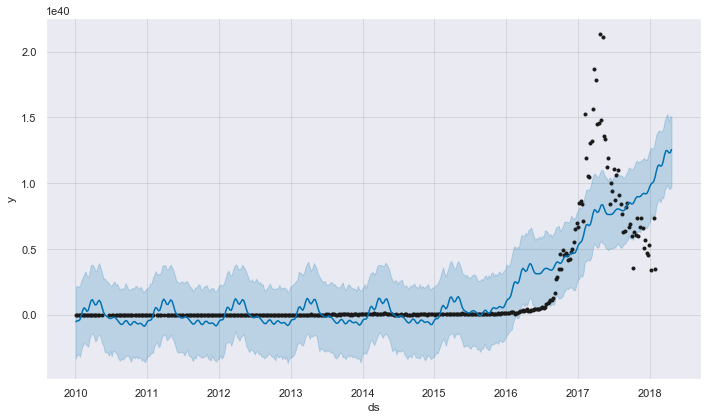

In [188]:
model.plot(forecast_data);

In [189]:
 from scipy.special import boxcox, inv_boxcox

In [201]:
inv_boxcox(lam,10)

1.5606621735322874